In [1]:
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
import requests
import json
from pprint import pprint
from config import gkey
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress

In [2]:
path='/Users/rafa/BootCamp/project1/'
bj_gdp=gpd.read_file(path+'shapes/conjunto_de_datos/09m.shp')

In [3]:
list(bj_gdp)

['CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'CVE_MZA', 'TIPOMZA', 'geometry']

### We only keep the CVE Municipalities (Alcaldies) of our interest, in this Case '014' is Benito Juarez

In [4]:
bj_gdp=bj_gdp[bj_gdp['CVE_MUN']=='014']
bj_gdp.head()

,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,TIPOMZA,geometry
489,09,014,0001,0670,009,Contenedora,"POLYGON ((2799670.579 822251.186, 2799688.149 ..."
490,09,014,0001,0670,007,Típica,"POLYGON ((2799834.281 822469.899, 2799837.093 ..."
491,09,014,0001,101A,011,Típica,"POLYGON ((2798987.855 820943.380, 2799000.745 ..."
492,09,014,0001,0933,014,Típica,"POLYGON ((2796104.968 821291.041, 2796147.356 ..."
493,09,014,0001,0863,034,Típica,"POLYGON ((2798625.523 822013.924, 2798691.143 ..."


<AxesSubplot:>

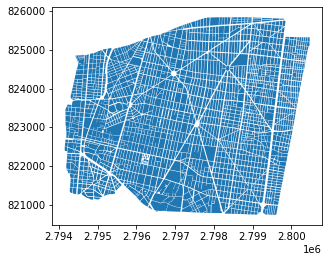

In [5]:
%matplotlib inline
bj_gdp.plot()

### Cleaning prices and finding lat and long

In [ ]:
# data=pd.read_csv(path+'TeamProject/clean_data.csv')

In [ ]:
# data.head()

In [ ]:
# data['price']=[int(i.replace(',','')) for i in data['price']]

In [ ]:
# data['lat']=''
# data['lng']=''

# for i in range(data.shape[0]):
    
#     # Build the endpoint URL
#     target_url = f'https://maps.googleapis.com/maps/api/geocode/json?address={data["adress"][i]}&key={gkey}'

#     geo_data = requests.get(target_url).json()

#     data['lat'][i] = geo_data["results"][0]["geometry"]["location"]["lat"]
#     data['lng'][i] = geo_data["results"][0]["geometry"]["location"]["lng"]

In [6]:
# data.to_csv('houses_gpd.csv',index=False)
data=pd.read_csv('houses_gpd.csv')

In [ ]:
# data.drop(columns=['Unnamed: 0'],inplace=True)

## Making lat & lon as geometry

In [7]:
geometry =[Point(xy) for xy in zip(data['lng'],data['lat'])]
crs={'init':'epsg:4326'}
points_gpd=gpd.GeoDataFrame(data,crs=crs,geometry=geometry)

/Users/rafa/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [8]:
points_gpd.head()

,m2,state,rooms,price,status,adress,lat,lng,geometry
0,281,construidos,4 recs.,8500000,Casa en venta,"Lopez Cotilla , Del Valle Sur , Benito Juárez...",19.372810,-99.168379,POINT (-99.16838 19.37281)
1,423,construidos,NaN,17000000,Casa en venta,"Del Valle Centro , Benito Juárez , Distrito F...",19.379715,-99.167713,POINT (-99.16771 19.37972)
2,488,construidos,6 recs.,11495000,Casa en venta,"Xochicalco , Narvarte Poniente , Benito Juáre...",19.390451,-99.154151,POINT (-99.15415 19.39045)
3,389,construidos,5 recs.,11000000,Casa en venta,"Tajin 20 , Narvarte Poniente , Benito Juárez ...",19.402970,-99.152377,POINT (-99.15238 19.40297)
4,258,construidos,4 recs.,11400000,Casa en venta,"Porfirio Díaz 156 , Del Valle Centro , Benito...",19.381927,-99.171952,POINT (-99.17195 19.38193)


## We have to check if the Coordinate reference system (CRS) of both geodataframes are equal, if not, we have to set the equal

In [19]:
points_gpd.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [33]:
bj_gdp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# Changing CRS in Benito Juarez
bj_gdp.to_crs('epsg:4326',inplace=True)

### Spatia join

In [10]:
points_gdp2=sjoin(points_gpd,bj_gdp,how='left')

<ipython-input-10-50ef5b8487da>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  points_gdp2=sjoin(points_gpd,bj_gdp,how='left')


In [11]:
# Finding if there are points outside the Alcaldia
bounderies=bj_gdp.geometry.bounds

In [12]:
list(bounderies)

['minx', 'miny', 'maxx', 'maxy']

In [13]:
min_x=bounderies['minx'].min()
min_y=bounderies['miny'].min()
max_x=bounderies['maxx'].max()
max_y=bounderies['maxy'].max()


In [15]:
cl=(~points_gdp2['CVE_ENT'].isna())

points_gdp2=points_gdp2[cl]

In [16]:
points_gdp2['id']=points_gdp2['CVE_LOC']+points_gdp2['CVE_AGEB']+points_gdp2['CVE_MZA']

In [17]:
cl=(points_gdp2['lat']>max_y)|(points_gdp2['lat']<min_y)|(points_gdp2['lng']>max_x)|(points_gdp2['lng']<min_x)
points_gdp2=points_gdp2[~cl]

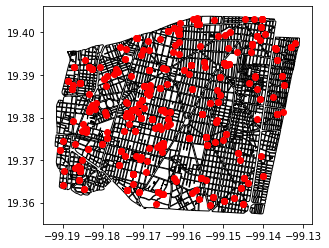

In [18]:
ax = bj_gdp.plot(color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
points_gdp2.plot(ax=ax, color='red')

plt.show()

In [19]:
points_gdp2['price_m2']=points_gdp2['price']/points_gdp2['m2']

In [82]:
list(points_gdp2)

['index',
 'm2',
 'state',
 'rooms',
 'price',
 'status',
 'adress',
 'lat',
 'lng',
 'geometry',
 'index_right',
 'CVE_ENT',
 'CVE_MUN',
 'CVE_LOC',
 'CVE_AGEB',
 'CVE_MZA',
 'TIPOMZA',
 'id',
 'price_m2']

### Loading Alcaldias attribures

In [22]:
attr=pd.read_csv('/Users/rafa/Downloads/ageb_mza_urbana_09_cpv2020_csv/conjunto_de_datos/conjunto_de_datos_ageb_urbana_09_cpv2020.csv')

/Users/rafa/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (178) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [23]:
cl=(attr['ENTIDAD']==9)&(attr['MUN']==14)
attr=attr[cl]

In [24]:
def zero_plus(item,digits):
    i=str(item)
    zeros=digits-len(i)
    return zeros*'0'+i

In [25]:
attr['MUN']=[zero_plus(i,3) for i in attr['MUN']]
attr['LOC']=[zero_plus(i,4) for i in attr['LOC']]
attr['AGEB']=[zero_plus(i,4) for i in attr['AGEB']]
attr['MZA']=[zero_plus(i,3) for i in attr['MZA']]

In [26]:
attr['id']=attr['LOC']+attr['AGEB']+attr['MZA']

In [27]:
attr.tail()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,POBFEM,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,id
56914,9,Ciudad de México,14,Benito Juárez,0001,Benito Juárez,1024,022,69,40,...,29,29,22,13,7,0,0,*,0,00011024022
56915,9,Ciudad de México,14,Benito Juárez,0001,Benito Juárez,1024,023,178,85,...,64,57,42,35,19,0,*,7,0,00011024023
56916,9,Ciudad de México,14,Benito Juárez,0001,Benito Juárez,1024,024,80,43,...,21,17,11,10,4,0,0,5,0,00011024024
56917,9,Ciudad de México,14,Benito Juárez,0001,Benito Juárez,1024,025,124,72,...,39,38,31,32,13,*,*,0,0,00011024025
56918,9,Ciudad de México,14,Benito Juárez,0001,Benito Juárez,1024,026,97,63,...,36,33,29,23,9,0,0,*,0,00011024026


In [28]:
names_20=list(attr)

In [29]:
names_20=[i.lower() for i in names_20]
dic_names=dict(zip(list(attr),names_20))

In [30]:
attr.rename(columns=dic_names,inplace=True)

## Datos 2010

In [31]:
attr_10=pd.read_csv('/Users/rafa/Downloads/resultados_ageb_urbana_09_cpv2010/conjunto_de_datos/resultados_ageb_urbana_09_cpv2010.csv')


In [32]:
cl=[i in list(attr_10) for i in list(attr)]
subset_names=list(compress(names_20, cl))

#id wasn't in 2010s'names
subset_names.append('id')

The next list of variables is not in 2010 set of variables

In [41]:
list(compress(names_20, ~np.array(cl)))

['pres2015',
 'pres2015_f',
 'pres2015_m',
 'presoe15',
 'presoe15_f',
 'presoe15_m',
 'pob_afro',
 'pob_afro_f',
 'pob_afro_m',
 'pcon_disc',
 'pcdisc_mot',
 'pcdisc_vis',
 'pcdisc_leng',
 'pcdisc_aud',
 'pcdisc_mot2',
 'pcdisc_men',
 'pcon_limi',
 'pclim_csb',
 'pclim_haco',
 'pclim_oaud',
 'pclim_re_co',
 'pclim_pmen',
 'psind_lim',
 'pafil_pdom',
 'pder_imssb',
 'pafil_ipriv',
 'pafil_otrai',
 'pro_crieva',
 'vph_aeasp',
 'vph_tinaco',
 'vph_cister',
 'vph_letr',
 'vph_ndeaed',
 'vph_dsadma',
 'vph_ndacmm',
 'vph_hmicro',
 'vph_moto',
 'vph_bici',
 'vph_stvp',
 'vph_spmvpi',
 'vph_cvj',
 'vph_sinrtv',
 'vph_sinltc',
 'vph_sincint',
 'vph_sintic',
 'id']

In [33]:
attr=attr[subset_names]

### Merge metros cubicos attributes and INEGI attributes

In [34]:
data=price_mz[['id','price_m2']].merge(attr,on='id',how='left')

In [35]:
data=data.replace('*','')

In [36]:
data.drop(columns=['entidad',
 'nom_ent',
 'mun',
 'nom_mun',
 'loc',
 'nom_loc',
 'ageb',
 'mza'],inplace=True)

In [37]:
X=data.drop(columns=['price_m2','id'])

In [38]:
y=data.price_m2

In [170]:
for col in list(X):
    X[col] = pd.to_numeric(X[col])

In [172]:
aux=X.head()

In [173]:
aux

,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,p_3ymas_f,p_3ymas_m,p_5ymas,...,vph_snbien,vph_refri,vph_lavad,vph_autom,vph_radio,vph_tv,vph_pc,vph_telef,vph_cel,vph_inter
0,215.0,111.0,104.0,4.0,NaN,3.0,211.0,110.0,101.0,208.0,...,0.0,97.0,72.0,44.0,77.0,92.0,82.0,67.0,98.0,84.0
1,733.0,375.0,358.0,15.0,5.0,10.0,718.0,370.0,348.0,706.0,...,0.0,308.0,281.0,224.0,252.0,303.0,279.0,241.0,305.0,297.0
2,300.0,160.0,140.0,4.0,NaN,NaN,296.0,158.0,138.0,292.0,...,0.0,124.0,94.0,70.0,99.0,118.0,110.0,100.0,119.0,112.0
3,308.0,162.0,146.0,7.0,3.0,4.0,301.0,159.0,142.0,290.0,...,NaN,105.0,89.0,69.0,94.0,103.0,94.0,84.0,105.0,95.0
4,487.0,243.0,244.0,7.0,3.0,4.0,480.0,240.0,240.0,477.0,...,0.0,216.0,170.0,98.0,143.0,202.0,177.0,161.0,214.0,202.0
